# Graded Exercise 2: Anomaly Detection on Acoustic Data

- **Course**: [CIVIL-426 - Machine Learning for Predictive Maintenance](https://edu.epfl.ch/coursebook/en/machine-learning-for-predictive-maintenance-applications-CIVIL-426)
- **Start Date**: 2024.10.03 at 10:15
- **Due Date**: 2024.10.23 at 23:59
- **Student 0**:
    - Name: `Fletcher Collis`
    - SCIPER: `315557`
- **Student 1**:
    - Name: `Luca Liuzzi`
    - SCIPER: `FILL HERE`

# Introduction
Anomalous sound detection (ASD) refers to the task of identifying whether the sounds emitted from a target machine are normal or anomalous.
In real-world industrial environments, anomalies are infrequent and can exhibit significant variability, making it impractical to build an exhaustive set of anomalous sound patterns.
As a result, our goal is to detect anomalous sounds using only normal sound clips for training.

This challenge cannot be approached as a simple classification problem (anomaly vs healthy). Instead, it is formulated as a **one-class classification** problem, where the model is trained on normal sound data to detect deviations from the learned pattern.

Anomalous sound detection can be achieved with following steps:
   - Feature Extraction (I)
   - One-class Classifier Training (II)
   - Decisions based on a threshold from your trained classifier (III)
   
Through this assignment, you will primarily focus on tasks (I) and (II).
The quality of your one-class classifier will be assessed using the **Area Under the Curve (AUC)** score on the test dataset.

The model used here is a type of neural network called **AutoEncoder** (AE). AE is trained to reconstruct the input data while compressing the input data into a lower-dimensional latent space and minimizing information loss during this process.
Thus, you will also modify the extracted features and Neural Network used in this notebook to improve the anomalous sound detection performance.

The dataset is composed of two different machines, a Pump and a Valve. For each machine you have:
- A **training dataset** composed of *only healthy* sound data
- A **test dataset** composed of *both healthy and abnormal* sound data

# Questions:

Your task is to improve the anomalous sound detection performance by modifying the feature extraction process and neural network architecture. You are expected to experiment with various feature representations and neural network configurations to optimize detection results.

Specifically, the following questions must be addressed. Each question should be discussed separately for both the Pump and Valve datasets. The answers are to be provided in a PDF report, and the full Jupyter notebook must also be submitted.

**Question 1:** Given the provided code, fill in the blank spaces to extract signal features, train a simple AutoEncoder that reconstructs the inputs MEL-Spectogram, and report the AUC score.

**Question 2:** From the trained AutoEncoder, use the bottleneck features to train both (1) a One-Class SVM and (2) an Isolation Forest, and report the corresponding AUC scores.

**Question 3:** Instead of using AutoEncoder features, apply PCA to project the MEL-spectrogram into a smaller dimensional space, then train (1) a One-Class SVM and (2) an Isolation Forest, and report the AUC scores.

**Question 4:** Determine an appropriate threshold for distinguishing anomalies based on the given results, and compute the following metrics: Accuracy, True Positive Rate (TPR), False Positive Rate (FPR), and F1-score.

**Question 5:** Visualize essential steps and provide a thorough discussion of the results obtained from all the methods.  

**Bonus Question:** Modify the AutoEncoder architecture to a 2D AutoEncoder using convolutional layers instead of fully connected layers, and analyze its performance.

## Download Dataset

In [1]:
%pip install gdown --upgrade --quiet
import gdown

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Pump Dataset
#gdown.download(id='1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn', output="./dev_data_pump_04.zip")

In [3]:
# Valve Dataset
#gdown.download(id='1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M', output="./dev_data_valve_00.zip")

In case that above links do not work, you can also manully download the dataset here:
- **dev_data_pump_04.zip**: https://docs.google.com/uc?export=download&id=1ZAqnNW2gnHDyFHGHk3Aru7k-ng-BTpGn
- **dev_data_valve_00,zip**: https://docs.google.com/uc?export=download&id=1H_SS7qteLcd44e5CD9CFJjhJ573FAb6M

In [4]:
#!unzip dev_data_pump_04.zip
#!unzip dev_data_valve_00.zip

## Import Dependency

In [5]:
import os
import sys
import librosa
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tqdm import tqdm

## Audio Data Loading and MEL-Spectrogram Feature Extraction

The code is adapted from https://github.com/MIMII-hitachi/mimii_baseline

Copyright (C) 2019 Hitachi, Ltd. All right reserved.

Harsh Purohit, Ryo Tanabe, Kenji Ichige, Takashi Endo, Yuki Nikaido, Kaori Suefusa, and Yohei Kawaguchi, "MIMII Dataset: Sound Dataset for Malfunctioning Industrial Machine Investigation and Inspection," arXiv preprint arXiv:1909.09347, 2019.

In [6]:
########################################################################
# import additional python-library
########################################################################
import librosa.core
import librosa.feature

# WAV File Input
def load_wav_files(wav_file_name, mono=True):
    """Load a .wav file."""
    try:
        return librosa.load(wav_file_name, sr=None, mono=mono)
    except Exception as e:
        print(f"Failed to load file '{wav_file_name}'. Error: {e}")
        raise

def demux_wav_files(wav_file_name, channel=0):
    """Demux a .wav file and return a specific channel."""
    try:
        multi_channel_data, sr = load_wav_files(wav_file_name, mono=False)
        if multi_channel_data.ndim == 1:
            return sr, multi_channel_data
        return sr, multi_channel_data[channel, :]
    except ValueError as e:
        print(f"Error in demuxing file '{wav_file_name}': {e}")
        raise

# Feel free to modify and analysis the images in your report
def plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram):

    plt.figure(1)

    n = len(y)
    t = np.linspace(tmin, tmax, n)
    plt.plot(t, y)
    plt.xlim(t[0],t[-1])
    plt.xlabel('time/s',fontsize=20)
    plt.ylabel('Amplitude',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid()
    
    plt.figure(2)

    freq = sr/n*np.linspace(0,n/2,int(n/2)+1)
    plt.plot(freq,np.absolute(np.fft.rfft(y[tmin*sr:tmax*sr],n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)
    
    plt.figure(3)

    plt.plot(freq,np.absolute(np.fft.rfft(emphasized_y,n)**2)/n)
    plt.xlim(0,5000)
    plt.xlabel('Frequency/Hz',fontsize=14)

    plt.figure(4)

    librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Mel Frequency (Hz)', fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #plt.savefig("Mel_spectrogram_pump")

########################################################################
# Feature Extractor
########################################################################
def file_to_features(file_name,
                     n_mels=64,
                     frames=5,
                     n_fft=1024,
                     hop_length=512,
                     power=2.0,
                     plot=True):
    
    """Convert a WAV file to a vector array."""

    # Step 01: Load the demuxed wav files
    sr, y = demux_wav_files(file_name, channel=0)
    
    # Step 02: Signal Pre-emphasis
    tmin = int(0)
    tmax = int(len(y)/sr)
    alpha = 0.95
    emphasized_y = np.append(y[0],
                             y[1:] - alpha*y[:-1])
    
    # Step 03: Generate MEL-Spectrogram
    # ===================================
    # IMPLEMENT YOUR CODE HERE
    # ===================================

    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power)
    

    # Step 04: Convert MEL-Spectrogram to log scale
    # ===================================
    # IMPLEMENT YOUR CODE HERE
    # ===================================

    #log_mel_spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spectrogram = 20 / power * np.log10(mel_spec + sys.float_info.epsilon)
    
    # Step 05: Define Feature Vector Array
    dims = n_mels * frames
    length = len(log_mel_spectrogram[0,:]) - frames + 1
    features = np.zeros((length, dims), float)
    
    # Pad short clips instead of skipping
    if length < 1:
        print(f"Audio file '{file_name}' is too short. Padding applied.")
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, frames - 1)), mode='constant')
        length = 1
    
    for t in range(frames):
        features[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + length].T
    
    if plot:
        plot_signals(tmin, tmax, sr, y, emphasized_y, log_mel_spectrogram)
    return features

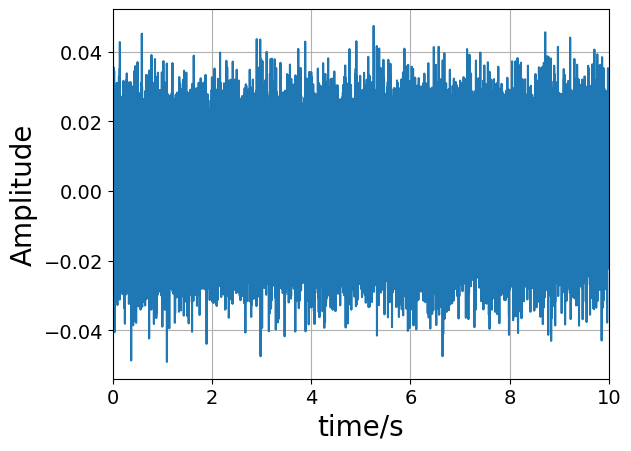

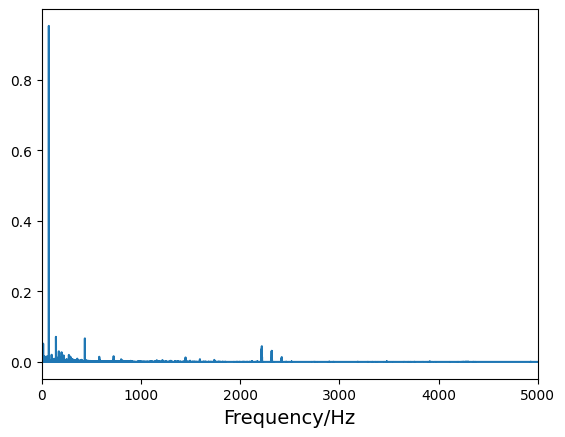

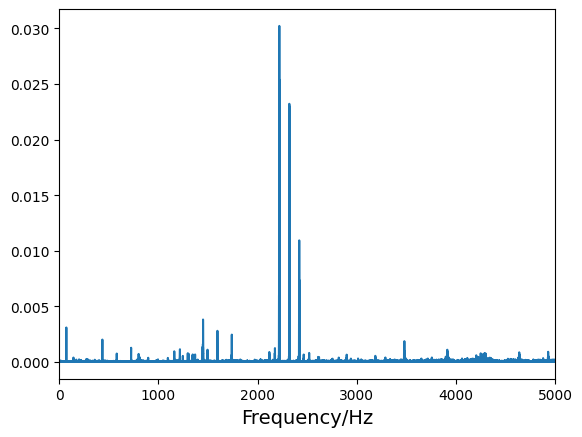

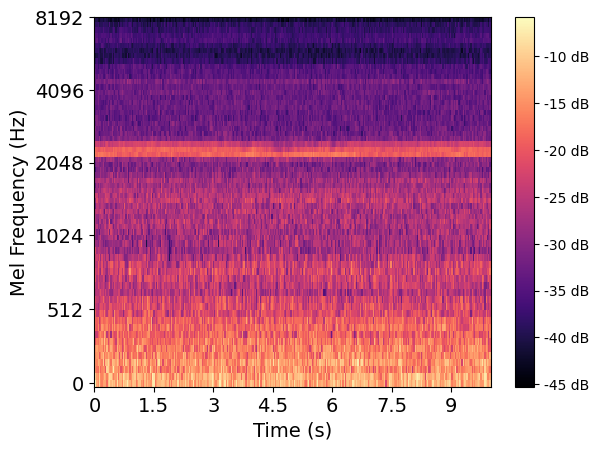

In [7]:
wav_test_file = 'dev_data_pump_04/pump/train/normal_id_04_00000000.wav'
# wav_test_file = 'dev_data_pump_04/pump/test/anomaly_id_04_00000000.wav'

# Visualize your results for potential analysis in your report
features = file_to_features(wav_test_file)

## PyTorch Dataset Splitting

To define and optimize a neural network, we will use the library [PyTorch](http://pytorch.org).

In [8]:
DATA_PATH = "."
MACHINE = "pump_04" # Choice between  "valve_00" or "pump_04"

In [9]:
class MIMII(Dataset):
    def __init__(self, root, machine, train=True, transform=None, target_transform=None):
        if train:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "train")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        else:
            self.audio_path = os.path.join(root, f"dev_data_{machine}", machine.split("_")[0], "test")
            self.audio_files = os.listdir(self.audio_path)
            self.labels = [int(f.split("_")[0] == "anomaly") for f in self.audio_files]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.audio_path, self.audio_files[idx])
        label = self.labels[idx]
        if self.transform:
            f = self.transform(file_path)
        else:
            # default feature representation
            f = file_to_features(file_path).astype(np.float32)
        if self.target_transform:
            label = self.target_transform(label)
        return f, label

In [10]:
# Parameters of the feature extraction
melsp_params = dict(n_mels=64,
                    frames=10,
                    n_fft=1024,
                    hop_length=512,
                    power=2.0,
                    plot=False)


feature_extraction_pipeline = T.Compose([
    T.Lambda(lambda file: file_to_features(file, **melsp_params).astype(np.float32)),
    T.ToTensor()
])

In [11]:
# Pytorch train/test datasets
data_train = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=True,
    transform=feature_extraction_pipeline
)

data_test = MIMII(
    root=DATA_PATH,
    machine=MACHINE,
    train=False,
    transform=feature_extraction_pipeline
)

## AutoEncoder Model Definition

In [12]:
class DenseAutoencoder(nn.Module):

    def __init__(self, input_dim):

        super(DenseAutoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            )
        
        # TODO : write a symetrical neural network to the encoder to reconstuct the input
        # ===================================
        # IMPLEMENT YOUR CODE HERE
        # ===================================

        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512,input_dim),
            )

    def forward(self, x):
        feature = self.encoder(x)
        reconstruction = self.decoder(feature)
        return reconstruction,feature

In [13]:
duration = 10  # s
sr = 16000  # Hz
input_dim = int(duration * sr / melsp_params["hop_length"] + 1) * melsp_params["n_mels"] * melsp_params["frames"]
print(input_dim)

# Here there is a bug in the given code, the definition for input_dim is wrong, therefor we decided to define it ourselves with the correct value

input_dim = 194560
print(input_dim)

model = DenseAutoencoder(input_dim)

200320
194560


## Training

In [14]:
# Training parameters
batch_size = 32
epochs = 10

In [15]:
# PyTorch data loaders allow to iterate batch-wise over a dataset
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True)

In [16]:
# Stochastic gradient descent optimizer
optimizer = torch.optim.Adam(model.parameters())

# Mean Squared Error (MSE) loss function to be minimized
loss_fn = nn.MSELoss()

In [17]:
def train_loop(dataloader, model, loss_fn, optimizer, print_every=10):

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss_running = 0

    for batch, (x, y) in enumerate(tqdm(dataloader)):

        #print(f"Original input shape: {x.shape}") 
        #x = x.flatten(start_dim=1)  # Flatten the input tensor
        #print(f"Flattened input shape: {x.shape}")  

        # Compute prediction and loss
        x = x.flatten(start_dim=1)
        optimizer.zero_grad()
        x_pred, features = model(x)

        #print(f"Flattened input shape: {x_pred.shape}") 

        
        # TODO : write the loss function, compute the gradient, and update the model parameters
        # ===================================
        # IMPLEMENT YOUR CODE HERE
        # ===================================

        loss = loss_fn(x_pred, x)
        loss.backward()

        optimizer.step()
        
        # Back Propagation
        loss_running += loss.item()
    print(f"loss: {loss_running/len(dataloader):>7f}")


def test_loop(dataset, model, loss_fn):
    size = len(dataset)
    test_losses = np.zeros(size)
    store_feature = []
    with torch.no_grad():
        for idx, (x, _) in enumerate(dataset):
            x = x.flatten()
            x_pred,features = model(x)
            store_feature.append(features.detach().cpu().numpy())
            test_losses[idx] = loss_fn(x_pred, x).item()

    return test_losses, np.array(store_feature)

In [18]:
%%time
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer, print_every=1);

Epoch 1
-------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:25<00:00,  1.41s/it]


loss: 839.284554
Epoch 2
-------------------------------


100%|██████████| 18/18 [00:22<00:00,  1.23s/it]


loss: 30.863976
Epoch 3
-------------------------------


100%|██████████| 18/18 [00:21<00:00,  1.18s/it]


loss: 17.660100
Epoch 4
-------------------------------


100%|██████████| 18/18 [00:15<00:00,  1.14it/s]


loss: 12.838353
Epoch 5
-------------------------------


100%|██████████| 18/18 [00:16<00:00,  1.06it/s]


loss: 12.310041
Epoch 6
-------------------------------


100%|██████████| 18/18 [00:21<00:00,  1.19s/it]


loss: 12.966733
Epoch 7
-------------------------------


100%|██████████| 18/18 [00:17<00:00,  1.04it/s]


loss: 12.286072
Epoch 8
-------------------------------


100%|██████████| 18/18 [00:16<00:00,  1.08it/s]


loss: 12.053529
Epoch 9
-------------------------------


100%|██████████| 18/18 [00:17<00:00,  1.02it/s]


loss: 12.323165
Epoch 10
-------------------------------


100%|██████████| 18/18 [00:15<00:00,  1.15it/s]

loss: 12.526952
CPU times: user 5min 51s, sys: 3min 9s, total: 9min 1s
Wall time: 3min 10s


## Prediction and Evaluation

In [19]:
y_true = data_test.labels
test_losses, extracted_features_test = test_loop(data_test, model, loss_fn)
y_scores = test_losses

metrics.roc_auc_score(y_true, y_scores)

# TODO : Define a threshold based on test loss for classification
# TODO : Report accuracy, TPR, FPR, F1-Score
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

np.float64(0.8084)

In [20]:
mean_loss = np.mean(test_losses)
std_loss = np.std(test_losses)

# Set the threshold to mean + 1.5 * std deviation
threshold = mean_loss 

print(f"The chosen threshold = {threshold}")

#threshold = 16

The chosen threshold = 16.107909719944


In [21]:
# By looking at the given code, anomalies are denoted as "1" and normal samples as "0"

pred_labels = []

for i in range(len(y_scores)):
    if test_losses[i] <= threshold :
        pred_labels.append(0)
    elif y_scores[i] > threshold :
        pred_labels.append(1)

print(len(pred_labels))

print(pred_labels)

print(y_true)

200
[1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1]
[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1

In [22]:
acc = metrics.accuracy_score(y_true, pred_labels)
print(f"Accuracy = {acc}")

tpr = metrics.recall_score(y_true, pred_labels)
print(f"True positive rate = {tpr}")

tn, fp, fn, tp = metrics.confusion_matrix(y_true, pred_labels).ravel()
fpr = fp / (fp + tn)
print(f"False positive rate = {fpr}")

F1 = metrics.f1_score(y_true, pred_labels)
print(f"F1 score = {F1}")


Accuracy = 0.71
True positive rate = 0.71
False positive rate = 0.29
F1 score = 0.71


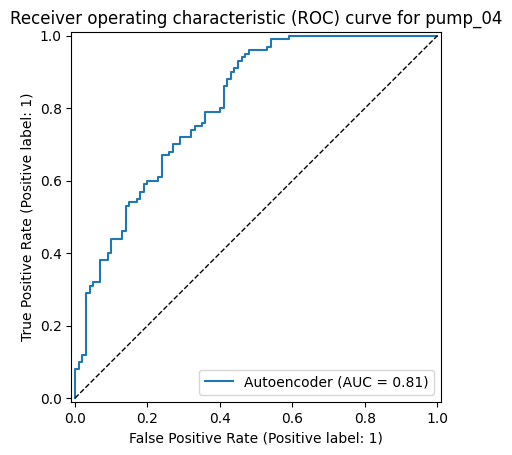

In [23]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_true, y_scores, name="Autoencoder")
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.title(f"Receiver operating characteristic (ROC) curve for {MACHINE}");
#plt.savefig("ROC curve autoencoder")

## One-Class SVM and Isolation Forest

From the trained AutoEncoder, use the bottleneck features to train a (1) One-Class SVM and (2) Isolation Forest, and report the accuracy, F1-score and auc score of each method.

In [24]:
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

In [25]:
# Get normal training features
y_pred_train, extracted_features_train = test_loop(data_train, model, loss_fn)


In [26]:
print(y_pred_train.shape)
print(extracted_features_train.shape)

(602,)
(602, 32)


### One-Class SVM

In [27]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using training data
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

# Initialize OneClassSVM with a few hyperparameters
svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)  # nu is the anomaly proportion

# Train the model on normal data (assumes X_train contains only normal data)
svm_model.fit(extracted_features_train)

# Predict anomalies (-1 = anomaly, 1 = normal)
y_pred_SVM = svm_model.predict(extracted_features_test)

for i in range(len(y_pred_SVM)):
    if y_pred_SVM[i] == -1:
        y_pred_SVM[i] = 1
    elif y_pred_SVM[i] == 1:
        y_pred_SVM[i] = 0

predicted_scores_SVM = svm_model.decision_function(extracted_features_test)


#print(y_pred_SVM)

metrics.roc_auc_score(y_true, -predicted_scores_SVM)

np.float64(0.6398)

In [28]:
acc = metrics.accuracy_score(y_true, y_pred_SVM)
print(f"Accuracy = {acc}")

tpr = metrics.recall_score(y_true, y_pred_SVM)
print(f"True positive rate = {tpr}")

tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_SVM).ravel()
fpr = fp / (fp + tn)
print(f"False positive rate = {fpr}")

F1 = metrics.f1_score(y_true, y_pred_SVM)
print(f"F1 score = {F1}")

Accuracy = 0.59
True positive rate = 0.83
False positive rate = 0.65
F1 score = 0.6693548387096774


### Isolation Forest

In [29]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using training data
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

iso_forest_model = IsolationForest(n_estimators=100, contamination=0.5, random_state=42)

iso_forest_model.fit(extracted_features_train)

y_pred_iso_forest = iso_forest_model.predict(extracted_features_test)

for i in range(len(y_pred_iso_forest)):
    if y_pred_iso_forest[i] == -1:
        y_pred_iso_forest[i] = 1  # anomaly
    elif y_pred_iso_forest[i] == 1:
        y_pred_iso_forest[i] = 0  # normal

predicted_scores_iso_forest = iso_forest_model.decision_function(extracted_features_test)


metrics.roc_auc_score(y_true, -predicted_scores_iso_forest)

np.float64(0.5820000000000001)

In [30]:
acc = metrics.accuracy_score(y_true, y_pred_iso_forest)
print(f"Accuracy = {acc}")

tpr = metrics.recall_score(y_true, y_pred_iso_forest)
print(f"True positive rate = {tpr}")

tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred_iso_forest).ravel()
fpr = fp / (fp + tn)
print(f"False positive rate = {fpr}")

F1 = metrics.f1_score(y_true, y_pred_iso_forest)
print(f"F1 score = {F1}")

Accuracy = 0.545
True positive rate = 0.59
False positive rate = 0.5
F1 score = 0.5645933014354066


PCA of the spectrograms to reduce the input dimension

In [31]:
# Extract spectrograms of training and testing
flatten_spectogram_train = []
for idx, (x, _) in enumerate(data_train):
    x = x.flatten()
    flatten_spectogram_train.append(x.numpy())
train_spec = np.array(flatten_spectogram_train)

flatten_spectogram_test = []
for idx, (x, _) in enumerate(data_test):
    x = x.flatten()
    flatten_spectogram_test.append(x.numpy())
test_spec = np.array(flatten_spectogram_test)

Apply PCA to fit and transform the training data and transform also the test data

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=64)

# TODO : Fit and transform the training data (train_spec)
# TODO : Transform the testing data (test_spec)
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

train_pca = pca.fit_transform(train_spec)

test_pca = pca.transform(test_spec)



Apply OneClassSVM and IsolationForest on the new PCA features.

In [33]:
# TODO : Define the OneClassSVM here
# TODO : Fit OneClassSVM here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

oc_svm = OneClassSVM(kernel='rbf', gamma='auto')  

oc_svm.fit(train_pca)

predicted_scores = oc_svm.decision_function(test_pca)

roc_auc = metrics.roc_auc_score(y_true, -predicted_scores)
print(f"ROC-AUC Score: {roc_auc:.4f}")

metrics.roc_auc_score(y_true, -predicted_scores)

ROC-AUC Score: 0.5000


np.float64(0.5)

In [34]:
# TODO : Define IsolationForest here
# TODO : Fit IsolationForest here using PCA features
# TODO : Report essential evaluation metrics
# ===================================
# IMPLEMENT YOUR CODE HERE
# ===================================

iso_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=42)

iso_forest.fit(train_pca)

predicted_scores = iso_forest.score_samples(test_pca)

roc_auc = metrics.roc_auc_score(y_true, -predicted_scores)  
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.8838
